## Importing Libraries used

In [1]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 47.6 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict, List

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, datasets

from timeit import default_timer as timer
from tqdm.auto import tqdm
from torchmetrics import Accuracy

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import requests
import zipfile
from pathlib import Path
import random
from PIL import Image
from collections import Counter


## Downloading Dataset from GitHub

In [3]:
data_path = Path('data')
image_path = data_path/'dataset'
zip_image_path = data_path/'dataset.zip'

if image_path.is_dir():
  print(f'{image_path} already exist... \nSkipping download')
else:
  print(f'{image_path} not found, creating {image_path}')
  image_path.mkdir(parents=True, exist_ok=True)

  with open(zip_image_path, 'wb') as f:
    request = requests.get('https://github.com/maheshkrishnam/SOI_SDS_2024/raw/main/train_data_with_classes.zip')
    print('Downloading dataset')
    f.write(request.content)

  with zipfile.ZipFile(zip_image_path, 'r') as zip_ref:
    print('Unzipping dataset')
    zip_ref.extractall(image_path)


data/dataset not found, creating data/dataset
Unzipping dataset


## Understanding and Visualizing the dataset

### Understating the structure of dataset

In [4]:
def walk_through_dir(image_path):
  for dirpath, dirnames, filenames in os.walk(image_path):
    if len(filenames) == 0:
      print(f'{dirpath} have directories {dirnames}')
    elif len(dirnames) == 0:
      print(f'{dirpath} having {len(filenames)} files')
    else :
      print(f'{dirpath} have directories {dirnames} having {len(filenames)} files')



In [5]:
walk_through_dir(image_path=image_path)

data/dataset have directories ['dark dune', 'spider', 'swiss cheese', 'slope streak', 'other', 'crater', 'impact ejecta', 'bright dune']
data/dataset/dark dune having 216 files
data/dataset/spider having 66 files
data/dataset/swiss cheese having 223 files
data/dataset/slope streak having 335 files
data/dataset/other having 3651 files
data/dataset/crater having 1062 files
data/dataset/impact ejecta having 51 files
data/dataset/bright dune having 597 files


In [6]:
dataset_dir = image_path

dataset_dir

PosixPath('data/dataset')

### Visualizing images

#### Using PIL library

Image Class : other
Image shape : (227, 227) | Image width : 227 | Image height : 227
Image filename : /content/data/dataset/other/1956.jpg
Image : <PIL.JpegImagePlugin.JpegImageFile image mode=L size=227x227 at 0x7EC1EEDC3040>


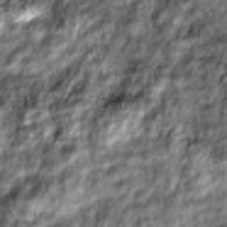

In [7]:
RANDOM_SEED = 0
random.seed(RANDOM_SEED)

pattern = '*/*.jpg'
image_path_list = list(image_path.glob(pattern))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
print(f'Image Class : {image_class}')
print(f'Image shape : {img.size} | Image width : {img.width} | Image height : {img.height}')
print(f'Image filename : {img.filename}')
print(f'Image : {img}')
img


#### Using Matplot

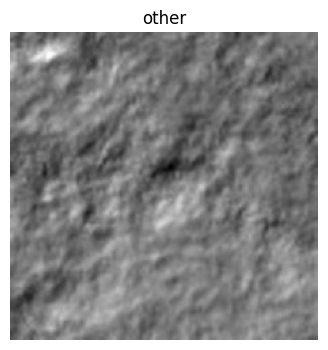

In [8]:
# preprocessing requires PIL library
plt.figure(figsize=(5,4))
plt.imshow(img, cmap='gray')
plt.title(image_class)
plt.axis('off')
plt.show()

## Loading dataset using ImageFolder

### Creating transforms

In [9]:
transform = transforms.Compose([
    transforms.Resize(size=(28, 28)),
    transforms.ToTensor()
])

transform

Compose(
    Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

### Converting Dataset using prebuild ImageFolder

In [10]:
whole_dataset = datasets.ImageFolder(
  root=dataset_dir,
  transform=transform,
  target_transform=None
)

whole_dataset

Dataset ImageFolder
    Number of datapoints: 6201
    Root location: data/dataset
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [11]:
whole_dataset[0]

(tensor([[[0.0000, 0.0039, 0.2745,  ..., 0.6588, 0.6510, 0.6314],
          [0.0000, 0.0039, 0.1529,  ..., 0.6588, 0.6392, 0.6549],
          [0.0000, 0.0000, 0.0706,  ..., 0.6510, 0.6471, 0.6510],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.6196, 0.6431, 0.6667],
          [0.0000, 0.0000, 0.0000,  ..., 0.6627, 0.6157, 0.6314],
          [0.0000, 0.0000, 0.0000,  ..., 0.6235, 0.5961, 0.6353]],
 
         [[0.0000, 0.0039, 0.2745,  ..., 0.6588, 0.6510, 0.6314],
          [0.0000, 0.0039, 0.1529,  ..., 0.6588, 0.6392, 0.6549],
          [0.0000, 0.0000, 0.0706,  ..., 0.6510, 0.6471, 0.6510],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.6196, 0.6431, 0.6667],
          [0.0000, 0.0000, 0.0000,  ..., 0.6627, 0.6157, 0.6314],
          [0.0000, 0.0000, 0.0000,  ..., 0.6235, 0.5961, 0.6353]],
 
         [[0.0000, 0.0039, 0.2745,  ..., 0.6588, 0.6510, 0.6314],
          [0.0000, 0.0039, 0.1529,  ..., 0.6588, 0.6392, 0.6549],
          [0.0000, 0.0000, 0.0706,  ...,

### Storing classes with their index

In [12]:
class_name_idx = whole_dataset.class_to_idx
class_name = whole_dataset.classes

class_name_idx, class_name

({'bright dune': 0,
  'crater': 1,
  'dark dune': 2,
  'impact ejecta': 3,
  'other': 4,
  'slope streak': 5,
  'spider': 6,
  'swiss cheese': 7},
 ['bright dune',
  'crater',
  'dark dune',
  'impact ejecta',
  'other',
  'slope streak',
  'spider',
  'swiss cheese'])

### Train Validation Split

In [13]:
train_dataset, val_dataset = train_test_split(whole_dataset, test_size=0.2, random_state=RANDOM_SEED)

len(train_dataset), len(val_dataset)

(4960, 1241)

### Plotting images

Image shape : torch.Size([3, 28, 28])
Image datatype : torch.float32


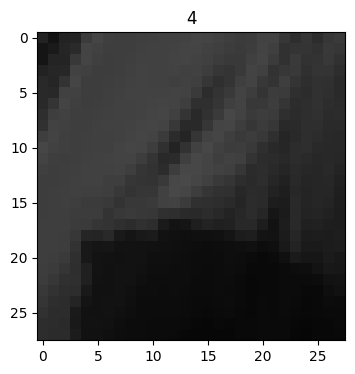

In [14]:
plt.figure(figsize=(5,4))
plt.imshow(train_dataset[0][0].permute(1,2,0))
plt.title(train_dataset[0][1])
print(f'Image shape : {train_dataset[0][0].shape}')
print(f'Image datatype : {train_dataset[0][0].dtype}')
plt.show()


### Assigning Weight to each Class

In [15]:
all_labels = [label for _, label in whole_dataset]
class_counts = Counter(all_labels)

total_count = len(all_labels)
class_weights = {cls: total_count / count for cls, count in class_counts.items()}
print(class_counts, class_weights)

sample_weights = [class_weights[label] for _, label in train_dataset]
val_sample_weights = [class_weights[label] for _, label in val_dataset]

sample_weights = torch.tensor(sample_weights, dtype=torch.float)
val_sample_weights = torch.tensor(val_sample_weights, dtype=torch.float)

len(sample_weights), len(val_sample_weights), sample_weights, val_sample_weights

Counter({4: 3651, 1: 1062, 0: 597, 5: 335, 7: 223, 2: 216, 6: 66, 3: 51}) {0: 10.386934673366834, 1: 5.838983050847458, 2: 28.708333333333332, 3: 121.58823529411765, 4: 1.6984387838948234, 5: 18.51044776119403, 6: 93.95454545454545, 7: 27.807174887892376}


(4960,
 1241,
 tensor([1.6984, 1.6984, 1.6984,  ..., 5.8390, 1.6984, 1.6984]),
 tensor([10.3869,  1.6984,  1.6984,  ...,  1.6984,  1.6984,  1.6984]))

#### Creating Sampler

In [16]:
sampler = torch.utils.data.WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

val_sampler = torch.utils.data.WeightedRandomSampler(
    weights=val_sample_weights,
    num_samples=len(val_sample_weights),
    replacement=True
)

sampler, val_sampler

(<torch.utils.data.sampler.WeightedRandomSampler at 0x7ec1e5d44cd0>,
 <torch.utils.data.sampler.WeightedRandomSampler at 0x7ec1e5d44820>)

### Converting Dataset in DataLoader

In [17]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    sampler=sampler
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=1,
    num_workers=NUM_WORKERS,
    sampler=val_sampler
)


In [18]:
image, label = next(iter(train_dataloader))
image.shape, label.shape

(torch.Size([32, 3, 28, 28]), torch.Size([32]))

## Model

### Defining Model Class

In [19]:
class Model(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(hidden_units),
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
      nn.BatchNorm2d(hidden_units),
      nn.Dropout(0.4)
    )
    self.block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units, out_channels=2*hidden_units, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(2*hidden_units),
      nn.Conv2d(in_channels=2*hidden_units, out_channels=2*hidden_units, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
      nn.BatchNorm2d(2*hidden_units),
      nn.Dropout(0.4)
    )
    self.block_3 = nn.Sequential(
      nn.Conv2d(in_channels=2*hidden_units, out_channels=2*hidden_units, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(2*hidden_units),
      nn.Conv2d(in_channels=2*hidden_units, out_channels=2*hidden_units, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
      nn.BatchNorm2d(2*hidden_units),
      nn.Dropout(0.4)
    )
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=2*hidden_units*3*3, out_features=256),
      nn.ReLU(),
      nn.Dropout(0.4),
      nn.Linear(in_features=256, out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
    # print(x.shape)
    x = self.block_1(x)
    # print(x.shape)
    x = self.block_2(x)
    # print(x.shape)
    x = self.block_3(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x


### Device agnostic code

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Making model out of the model class

In [21]:
model = Model(
    input_shape=3,
    hidden_units=64,
    output_shape=8
).to(device)

model

Model(
  (block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7):

### Early Stopping

In [22]:
class EarlyStopping:
  def __init__(self, patience=5, min_delta=0):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.best_loss = None
    self.early_stop = False

  def __call__(self, loss):
    if self.best_loss is None:
      self.best_loss = loss
    elif self.best_loss - loss > self.min_delta:
      self.best_loss = loss
      self.counter = 0
    elif self.best_loss - loss < self.min_delta:
      self.counter += 1
      if self.counter >= self.patience:
        self.early_stop = True

### Setting up the loss function, optimizer, accuracy metric, LR scheduler and earlystopping

In [23]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=0.003
)
accuracy_fn = Accuracy(task='multiclass', num_classes=8).to(device)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer=optimizer,
    step_size=10,
    gamma=0.2
)

early_stopping = EarlyStopping(patience=5, min_delta=0.01)

loss_fn, optimizer, accuracy_fn, scheduler, early_stopping

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     initial_lr: 0.003
     lr: 0.003
     maximize: False
     weight_decay: 0
 ),
 MulticlassAccuracy(),
 <__main__.EarlyStopping at 0x7ec1e5cfe860>)

### Training and Testing loop

In [24]:
EPOCHS = 50

start_time = timer()
train_loss_hist = []
train_acc_hist = []
val_loss_hist = []
val_acc_hist = []

for epoch in tqdm(range(EPOCHS)):
  print(f'\nEPOCH : {epoch+1} \n----------')

  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)

    y_logits = model(X)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y)
    acc = accuracy_fn(y_pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    train_acc += acc.item()

    if batch % 50 == 0:
      print(f'Looked at {(batch * len(X))/len(train_dataloader.dataset):.2f} samples')

  # scheduler.step()

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  train_loss_hist.append(train_loss)
  train_acc_hist.append(train_acc)

  print(f'Train Loss : {train_loss:.5f} | Train Accuracy : {train_acc:.3f}')

  model.eval()
  val_loss, val_acc = 0, 0
  with torch.inference_mode():
    for X, y in val_dataloader:
      X, y = X.to(device), y.to(device)

      val_logits = model(X)
      val_pred = torch.softmax(val_logits, dim=1).argmax(dim=1)

      val_loss += loss_fn(val_logits, y)
      val_acc += accuracy_fn(val_pred, y)

    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)
    val_loss_hist.append(val_loss.item())
    val_acc_hist.append(val_acc.item())

    print(f'Val Loss : {val_loss:.5f} | Val Accuracy : {val_acc:.3f}')

  # early_stopping(val_loss)
  # if early_stopping.early_stop:
  #   print("Early stopping")
  #   break

end_time = timer()
total_time = end_time - start_time
print(f'Total Time : {total_time:.3f} seconds\n')

print(f"Training Losses : {train_loss_hist}\n")
print(f"Training Accuracies : {train_acc_hist}\n")
print(f"Validation Losses : {val_loss_hist}\n")
print(f"Validation Accuracies : {val_acc_hist}")



  0%|          | 0/50 [00:00<?, ?it/s]


EPOCH : 1 
----------
Looked at 0.00 samples
Looked at 0.32 samples
Looked at 0.65 samples
Looked at 0.97 samples
Train Loss : 1.90917 | Train Accuracy : 0.317
Val Loss : 2.01178 | Val Accuracy : 0.334

EPOCH : 2 
----------
Looked at 0.00 samples
Looked at 0.32 samples
Looked at 0.65 samples
Looked at 0.97 samples
Train Loss : 1.35807 | Train Accuracy : 0.516
Val Loss : 1.61693 | Val Accuracy : 0.480

EPOCH : 3 
----------
Looked at 0.00 samples
Looked at 0.32 samples
Looked at 0.65 samples
Looked at 0.97 samples
Train Loss : 1.13643 | Train Accuracy : 0.595
Val Loss : 1.19524 | Val Accuracy : 0.564

EPOCH : 4 
----------
Looked at 0.00 samples
Looked at 0.32 samples
Looked at 0.65 samples
Looked at 0.97 samples
Train Loss : 0.92013 | Train Accuracy : 0.684
Val Loss : 1.53216 | Val Accuracy : 0.562

EPOCH : 5 
----------
Looked at 0.00 samples
Looked at 0.32 samples
Looked at 0.65 samples
Looked at 0.97 samples
Train Loss : 0.79793 | Train Accuracy : 0.721
Val Loss : 1.11818 | Val Ac

AttributeError: 'list' object has no attribute 'max'

In [28]:
print(f'Best Train Accuracy : {max(train_acc_hist):.3f}')
print(f'Best Val Accuracy : {max(val_acc_hist):.3f}')

Best Train Accuracy : 0.960
Best Val Accuracy : 0.795


## Evaluation

### Evaluation function

In [29]:
def eval_model(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn
):
  start_time = timer()

  loss, acc = 0, 0

  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      y_logits = model(X)

      loss += loss_fn(y_logits, y)
      acc += accuracy_fn(y_logits.argmax(dim=1), y)

    loss /= len(data_loader)
    acc /= len(data_loader)

  end_time = timer()

  return {
      'model_name': model.__class__.__name__,
      'model_acc': acc.item(),
      'model_loss': loss.item(),
      'model_eval_time': end_time-start_time
  }

In [30]:
model_dict = eval_model(
    model=model,
    data_loader=val_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

model_dict

{'model_name': 'Model',
 'model_acc': 0.7099113464355469,
 'model_loss': 1.282763123512268,
 'model_eval_time': 5.094738901000028}

### Prediction

In [31]:
y_pred = []
y_true = []
acc = 0
model.eval();
with torch.inference_mode():
  for X, y in val_dataloader:
    X, y = X.to(device), y.to(device)
    y_logits = model(X)
    y_pred_curr = torch.softmax(y_logits, dim=1).argmax(dim=1)
    acc += accuracy_fn(y_pred_curr, y)
    y_pred.append(y_pred_curr.item())
    y_true.append(y.item())
  acc /= len(val_dataloader)


In [32]:
print(f'Predictions : {y_pred}')
print(f'Actual : {y_true}')
print(f'Length of Predictions : {len(y_pred)}')
print(f'Length of Actual Values : {len(y_true)}')
print(f'Accuracy : {acc:.3f}')

Predictions : [4, 5, 5, 1, 2, 0, 5, 5, 1, 1, 5, 0, 0, 4, 4, 0, 1, 6, 4, 6, 1, 0, 4, 4, 0, 1, 0, 1, 1, 6, 2, 0, 0, 4, 0, 6, 6, 6, 5, 5, 0, 4, 0, 0, 2, 4, 4, 1, 7, 4, 4, 0, 5, 4, 5, 0, 1, 3, 4, 5, 3, 6, 4, 7, 7, 1, 4, 1, 5, 5, 3, 4, 4, 4, 4, 1, 4, 5, 2, 1, 2, 4, 3, 1, 4, 1, 0, 6, 1, 6, 5, 1, 0, 3, 7, 4, 4, 0, 1, 6, 0, 6, 5, 4, 2, 0, 4, 2, 4, 4, 4, 6, 2, 3, 0, 7, 4, 0, 7, 0, 4, 0, 6, 0, 5, 2, 4, 3, 5, 4, 0, 3, 5, 2, 0, 2, 0, 1, 6, 0, 5, 4, 3, 4, 7, 7, 1, 5, 4, 2, 5, 5, 2, 5, 5, 4, 1, 1, 7, 6, 2, 1, 4, 2, 5, 4, 3, 5, 7, 0, 1, 3, 2, 5, 1, 4, 0, 4, 6, 2, 4, 1, 4, 1, 0, 1, 6, 2, 4, 5, 1, 4, 6, 2, 6, 1, 2, 1, 5, 5, 5, 3, 5, 4, 4, 0, 4, 6, 4, 4, 6, 1, 4, 5, 2, 5, 4, 0, 0, 2, 2, 3, 4, 4, 4, 2, 4, 7, 4, 4, 2, 2, 6, 0, 0, 4, 0, 5, 0, 5, 2, 4, 5, 5, 4, 4, 6, 1, 4, 3, 0, 4, 3, 1, 5, 4, 4, 4, 4, 0, 7, 7, 4, 4, 4, 4, 2, 6, 1, 7, 5, 3, 4, 0, 0, 1, 7, 4, 2, 4, 6, 4, 0, 2, 2, 4, 5, 5, 4, 0, 0, 5, 0, 0, 0, 0, 4, 4, 0, 7, 2, 4, 5, 0, 5, 5, 1, 4, 3, 4, 2, 4, 1, 4, 2, 2, 4, 3, 6, 6, 5, 3, 1, 5, 4, 0, 5, 6, 4

#### Plotting Prediction vs Actual

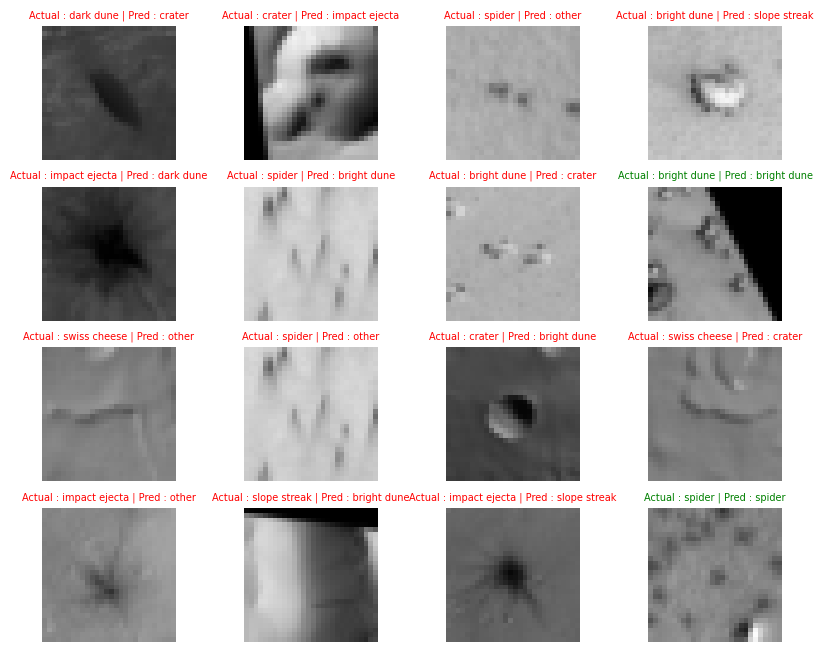

In [33]:
fig = plt.figure(figsize=(10, 8))

for i in range(16):
  plt.subplot(4, 4, i+1)
  random_idx = random.randint(0, len(val_dataloader))
  val_iter = iter(val_dataloader)
  for j in range(random_idx):
    X, y = next(val_iter)
  plt.imshow(X.squeeze().permute(1, 2, 0).detach().cpu(), cmap='gray')
  if(y != y_pred[random_idx]):
    plt.title(f'Actual : {class_name[y]} | Pred : {class_name[y_pred[random_idx]]}', c='r', fontsize=7)
  else:
    plt.title(f'Actual : {class_name[y]} | Pred : {class_name[y_pred[random_idx]]}', c='g', fontsize=7)
  plt.axis('off')
plt.show()

## Plotting Accuracy and Loss of train and val

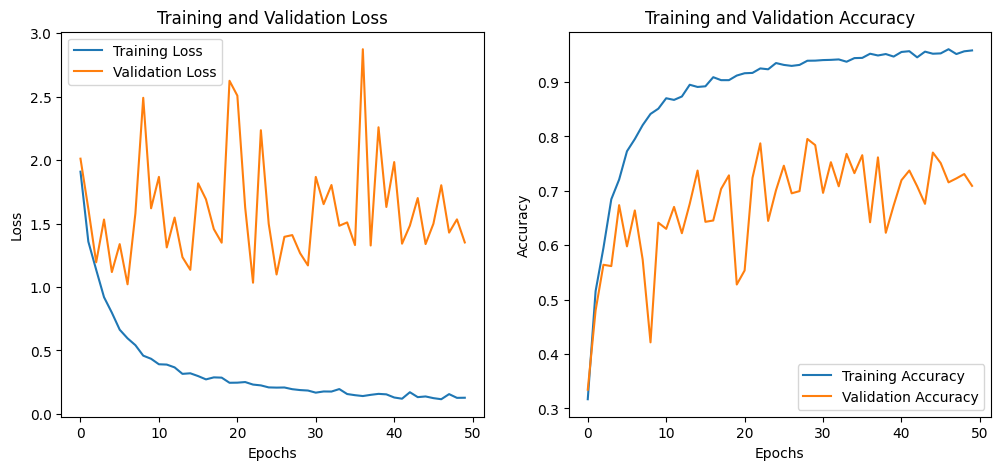

In [34]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss_hist, label='Training Loss')
plt.plot(val_loss_hist, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc_hist, label='Training Accuracy')
plt.plot(val_acc_hist, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Plotting Confusion Matrix

In [35]:
cf_matrix = confusion_matrix(y_true, y_pred)
num_classes_cf = cf_matrix.shape[0]
num_classes_names = len(class_name)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in class_name], columns = [i for i in class_name])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()